In [1]:
import numpy as np
import matplotlib.pyplot as plt

This script solves the linear 1.5 layer, reduced gravity, shallow water equations in transport form for a square 5000 km x 5000 km ocean domain, about the size of the North Atlantic ocean. 

In [68]:
# Define parameters

phi0 = 0 # central latitude of model domain in degrees

kmax = 3 # number of time levels 

Lx = 5e6
Ly = 5e6

dx = 1e5 # grid spacing in x
dx2 = dx * dx
rdx = 1 / dx
rdx2 = 1 / dx2

dy = dx # grid spacing in y
dy2 = dy * dy
rdy = 1 / dy
rdy2 = 1 / dy2

imax = int(Lx / dx + 1) 
jmax = int(Ly / dy + 1)

dt = 5400 # time step

# Perform an averaging step every nsmth timesteps
nsmth = 31

#beta = 2e-11 # Meridional gradient of Coriolis parameter, beta = df/dy
beta = 0

hl = 100 # thickness of the upper layer
gp = 9e-2 # reduced gravity
rho0 = 1025.0 # mean ocean density

ah = 2e4
Amax = dx * dx / (8 * dt)
if ah > Amax:
    print('WARNING: ah exceeds Amax')
    
# Define some constants to save operations
fcx = ah * rdx2
fcy = ah * rdy2
pgx = gp * rdx
pgy = gp * rdy

# Define run time parameters
ndays = 360
nsteps = int(ndays*86400 / dt)
iplot = int(30*86400 / dt)

# Define land-sea mask
masku = np.zeros((imax, jmax))
maskv = np.zeros((imax, jmax))
maskh = np.ones((imax, jmax))

maskh[:, 0] = maskh[:, -1] = maskh[0, :] = maskh[-1, :] = 0

for j in range(jmax):
    for i in range(imax - 1):
        masku[i, j] = maskh[i, j] * maskh[i + 1, j]
for j in range(jmax - 1):
    for i in range(imax):
        maskv[i, j] = maskh[i, j] * maskh[i, j + 1]

# Coriolis parameters (equator lies on a v-point)
phi = phi0 * np.pi/180 # latitude in radians
omega = 7.292e-5
je = int((jmax - 1) / 2 + 1)
f0 = 2* omega * np.sin(phi)

fv = np.array([f0 + (j - je) * dy * beta for j in range(jmax)])
fu = np.array([f0 + (j - je - 0.5) * dy * beta for j in range(jmax)])

In [69]:
# Define initial conditions
u = np.zeros((imax, jmax, kmax))
v = np.zeros((imax, jmax, kmax))
h = np.zeros((imax, jmax, kmax))

# Initial h with a square blob in the central basin
h[21:31, 21:31, 0] = 10
h[21:31, 21:31, 1] = 10

# Initialize plotting arrays
kplot = int(nsteps / iplot)
up = np.zeros((imax, jmax, kplot))
vp = np.zeros((imax, jmax, kplot))
hp = np.zeros((imax, jmax, kplot))

In [ ]:
# Time-stepping

km, kn, kp = 0, 1, 2
ipp = 0

for ntime in range(nsteps):
    if ntime % 500 == 0:
        print('timestep=', ntime)

    # Zonal momentum equation
    for j in range(1,jmax-1):
        for i in range(1,imax-1):    
            coriolis = (fv[j]*(v[i,j,kn]+v[i+1,j,kn])+fv[j-1]*(v[i,j-1,kn]+v[i+1,j-1,kn]))/4
            #coriolis = -(fv[j]*(v[i,j,kn]+v[i+1,j,kn])+fv[j-1]*(v[i,j-1,kn]+v[i+1,j-1,kn]))/4
    
            pg = gp*(hl-(h[i+1,j,kn]+h[i,j,kn])/2)*(h[i+1,j,kn]-h[i,j,kn])/dx
    
            diffx = fcx*(u[i+1,j,km]-2*u[i,j,km]+u[i-1,j,km])
            diffy = fcy*(u[i,j+1,km]-2*u[i,j,km]+u[i,j-1,km])
    
            u[i,j,kp] = u[i,j,km] + 2*dt*masku[i,j]*(coriolis+pg+diffx+diffy)

    # Meridional momentum equation
    for j in range(1,jmax-1):
        for i in range(1,imax-1):
            coriolis = -(fu[j]*(u[i-1,j,kn]+u[i,j,kn])+fu[j+1]*(u[i-1,j+1,kn]+u[i,j+1,kn]))/4
            #coriolis = +(fu[j]*(u[i-1,j,kn]+u[i,j,kn])+fu[j+1]*(u[i-1,j+1,kn]+u[i,j+1,kn]))/4
    
            pg = gp*(hl-(h[i,j+1,kn]+h[i,j,kn])/2)*(h[i,j+1,kn]-h[i,j,kn])/dy
    
            diffx = fcx*(v[i+1,j,km]-2*v[i,j,km]+v[i-1,j,km])
            diffy = fcy*(v[i,j+1,km]-2*v[i,j,km]+v[i,j-1,km])
    
            v[i,j,kp] = v[i,j,km] + 2*dt*maskv[i,j]*(coriolis+pg+diffx+diffy)

    # Continuity equation
    for j in range(1,jmax-1):
        for i in range(1,imax-1):
            div=((u[i,j,kn]-u[i-1,j,kn])/dx+(v[i,j,kn]-v[i,j-1,kn])/dy)
            h[i,j,kp] = h[i,j,km] + 2*dt*maskh[i,j]*div

    # Apply smoothing
    if (ntime % nsmth)==0:
        for j in range(1,jmax-1):
            for i in range(1,imax-1):
                u[i,j,kp] = 0.5*(u[i,j,kp]+u[i,j,kn])
                u[i,j,kn] = 0.5*(u[i,j,km]+u[i,j,kn])
                v[i,j,kp] = 0.5*(v[i,j,kp]+v[i,j,kn])
                v[i,j,kn] = 0.5*(v[i,j,km]+v[i,j,kn])
                h[i,j,kp] = 0.5*(h[i,j,kp]+h[i,j,kn])
                h[i,j,kn] = 0.5*(h[i,j,km]+h[i,j,kn])

    # Impose boundary conditions - no-slip
    u[:,0,kp] = -u[:,1,kp]
    u[:,-1,kp] = -u[:,-2,kp]
    v[0,:,kp] = -v[1,:,kp]
    v[-1,:,kp] = -v[-2,:,kp]

    # Advance timesteps
    ks = km  
    km = kn  
    kn = kp 
    kp = ks 

    # Plotting
    if (ntime%iplot)==0:
        up[:,:,ipp] = u[:,:,km]/(hl-(h[i+1,j,kn]+h[i,j,kn])/2)
        vp[:,:,ipp] = v[:,:,km]/(hl-(h[i,j+1,kn]+h[i,j,kn])/2)   
        hp[:,:,ipp] = h[:,:,km]
        ipp = ipp+1

timestep= 0
timestep= 500
timestep= 1000
timestep= 1500
timestep= 2000
timestep= 2500
timestep= 3000


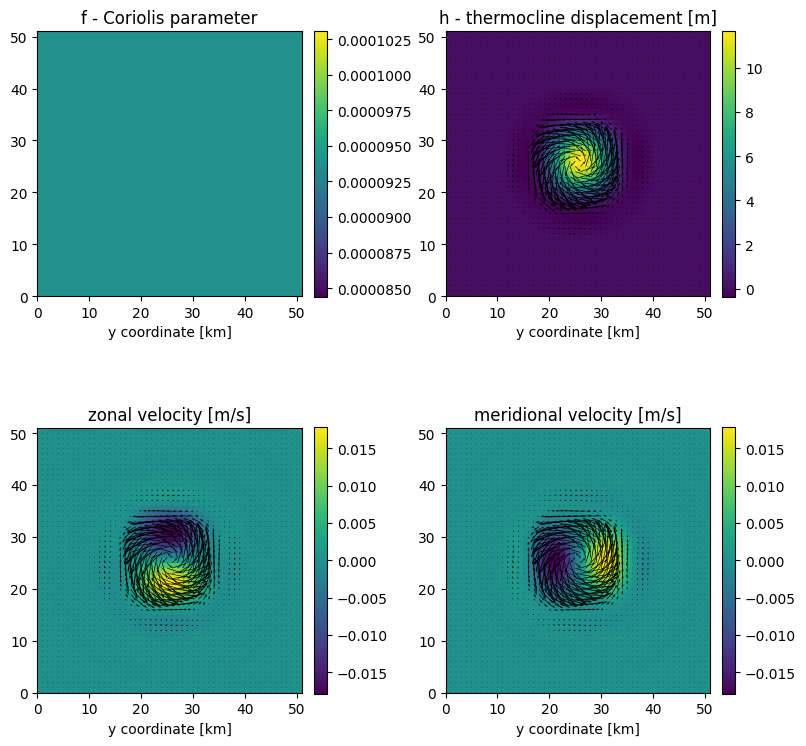

In [67]:
ind = -1

fplot = np.ones_like(hp[:,:,0])*fv

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
pcm = ax[0,0].pcolormesh(fplot, shading='auto') 
plt.colorbar(pcm, fraction=0.046, pad=0.04)
ax[0,0].set_title('f - Coriolis parameter')
ax[0,0].set_xlabel('x coordinate [km]')
ax[0,0].set_xlabel('y coordinate [km]')
ax[0,0].set_aspect('equal', 'box')

pcm = ax[0,1].pcolormesh(hp[:, :, ind].T, shading='auto') 
plt.colorbar(pcm, fraction=0.046, pad=0.04)
ax[0,1].quiver(up[:, :, ind].T, vp[:, :, ind].T)
ax[0,1].set_title('h - thermocline displacement [m]')
ax[0,1].set_xlabel('x coordinate [km]')
ax[0,1].set_xlabel('y coordinate [km]')
ax[0,1].set_aspect('equal', 'box')

pcm = ax[1,0].pcolormesh(up[:, :, ind].T, shading='auto') 
plt.colorbar(pcm, fraction=0.046, pad=0.04)
ax[1,0].quiver(up[:, :, ind].T, vp[:, :, ind].T)
ax[1,0].set_title('zonal velocity [m/s]')
ax[1,0].set_xlabel('x coordinate [km]')
ax[1,0].set_xlabel('y coordinate [km]')
ax[1,0].set_aspect('equal', 'box')

pcm = ax[1,1].pcolormesh(vp[:, :, ind].T, shading='auto') 
plt.colorbar(pcm, fraction=0.046, pad=0.04)
ax[1,1].quiver(up[:, :, ind].T, vp[:, :, ind].T)
ax[1,1].set_title('meridional velocity [m/s]')
ax[1,1].set_xlabel('x coordinate [km]')
ax[1,1].set_xlabel('y coordinate [km]')
ax[1,1].set_aspect('equal', 'box')

fig.tight_layout(pad=0.5)
